## Upload dataset

In [1]:
from google.colab import files
uploaded = files.upload()

Saving KC3.arff to KC3.arff


## Install new version of scikit-learn

In [2]:
!pip uninstall scikit-learn -y
!pip install -U scikit-learn

Found existing installation: scikit-learn 1.0.1
Uninstalling scikit-learn-1.0.1:
  Successfully uninstalled scikit-learn-1.0.1
     |████████████████████████████████| 23.2 MB 116 kB/s 


## Import required libraries

In [3]:
from scipy.io.arff import loadarff
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import matthews_corrcoef

## Load dataset

In [4]:
raw_data = loadarff("KC3.arff")
data = pd.DataFrame(raw_data[0])
data['Defective'] = data['Defective'].apply(lambda x: 1 if x.decode() == 'Y' else 0)
data.head()

,LOC_BLANK,BRANCH_COUNT,CALL_PAIRS,LOC_CODE_AND_COMMENT,LOC_COMMENTS,CONDITION_COUNT,CYCLOMATIC_COMPLEXITY,CYCLOMATIC_DENSITY,DECISION_COUNT,DECISION_DENSITY,DESIGN_COMPLEXITY,DESIGN_DENSITY,EDGE_COUNT,ESSENTIAL_COMPLEXITY,ESSENTIAL_DENSITY,LOC_EXECUTABLE,PARAMETER_COUNT,GLOBAL_DATA_COMPLEXITY,GLOBAL_DATA_DENSITY,HALSTEAD_CONTENT,HALSTEAD_DIFFICULTY,HALSTEAD_EFFORT,HALSTEAD_ERROR_EST,HALSTEAD_LENGTH,HALSTEAD_LEVEL,HALSTEAD_PROG_TIME,HALSTEAD_VOLUME,MAINTENANCE_SEVERITY,MODIFIED_CONDITION_COUNT,MULTIPLE_CONDITION_COUNT,NODE_COUNT,NORMALIZED_CYLOMATIC_COMPLEXITY,NUM_OPERANDS,NUM_OPERATORS,NUM_UNIQUE_OPERANDS,NUM_UNIQUE_OPERATORS,NUMBER_OF_LINES,PERCENT_COMMENTS,LOC_TOTAL,Defective
0,12.0,15.0,20.0,1.0,7.0,16.0,9.0,0.17,8.0,2.00,7.0,0.78,56.0,5.0,0.50,52.0,1.0,7.0,0.78,99.00,17.94,31877.94,0.59,287.0,0.06,1771.00,1776.48,0.56,4.0,8.0,49.0,0.12,102.0,185.0,54.0,19.0,73.0,13.33,53.0,1
1,0.0,3.0,4.0,0.0,0.0,4.0,2.0,0.25,2.0,2.00,2.0,1.00,9.0,1.0,0.00,8.0,2.0,2.0,1.00,20.81,9.00,1685.67,0.06,42.0,0.11,93.65,187.30,0.50,1.0,2.0,9.0,0.22,15.0,27.0,10.0,12.0,9.0,0.00,8.0,0
2,3.0,5.0,3.0,0.0,1.0,6.0,3.0,0.27,2.0,3.00,2.0,0.67,13.0,3.0,1.00,11.0,1.0,1.0,0.33,29.72,13.60,5496.65,0.13,85.0,0.07,305.37,404.17,1.00,2.0,3.0,12.0,0.19,34.0,51.0,15.0,12.0,16.0,8.33,11.0,0
3,11.0,43.0,16.0,0.0,4.0,76.0,22.0,0.21,34.0,2.24,17.0,0.77,119.0,12.0,0.52,103.0,3.0,18.0,0.82,70.89,48.94,169799.06,1.16,557.0,0.02,9433.28,3469.45,0.55,21.0,38.0,99.0,0.18,208.0,349.0,51.0,24.0,119.0,3.74,103.0,0
4,9.0,11.0,13.0,0.0,9.0,8.0,8.0,0.10,4.0,2.00,5.0,0.63,43.0,1.0,0.00,79.0,2.0,7.0,0.88,123.35,19.27,45791.28,0.79,367.0,0.05,2543.96,2376.59,0.13,2.0,4.0,37.0,0.08,152.0,215.0,71.0,18.0,102.0,10.23,79.0,1


## Model Training and Testing without Feature Selection

In [5]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 10)

### K-Nearest Neighbour

In [6]:
knn = KNeighborsClassifier(n_neighbors = 89)
knn.fit(X_train, y_train)
print(f"Score: {knn.score(X_test, y_test)}")
y_pred = knn.predict(X_test)
print(f"MCC: {matthews_corrcoef(y_test, y_pred)}")

Score: 0.7627118644067796
MCC: 0.0


### Naive Bayes

In [7]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
print(f"Score: {gnb.score(X_test, y_test)}")
y_pred = gnb.predict(X_test)
print(f"MCC: {matthews_corrcoef(y_test, y_pred)}")

Score: 0.7288135593220338
MCC: 0.07596177114740713


### Decision Tree

In [8]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
print(f"Score: {dtc.score(X_test, y_test)}")
y_pred = dtc.predict(X_test)
print(f"MCC: {matthews_corrcoef(y_test, y_pred)}")

Score: 0.7966101694915254
MCC: 0.38516379630464104


### Random Forest

In [9]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
print(f"Score: {rfc.score(X_test, y_test)}")
y_pred = rfc.predict(X_test)
print(f"MCC: {matthews_corrcoef(y_test, y_pred)}")

Score: 0.7288135593220338
MCC: 0.008058229640253803


AdaBoost

In [10]:
abc = AdaBoostClassifier()
abc.fit(X_train, y_train)
print(f"Score: {abc.score(X_test, y_test)}")
y_pred = abc.predict(X_test)
print(f"MCC: {matthews_corrcoef(y_test, y_pred)}")

Score: 0.7457627118644068
MCC: 0.16497043696489358


## Correlation Matrix of Dataset

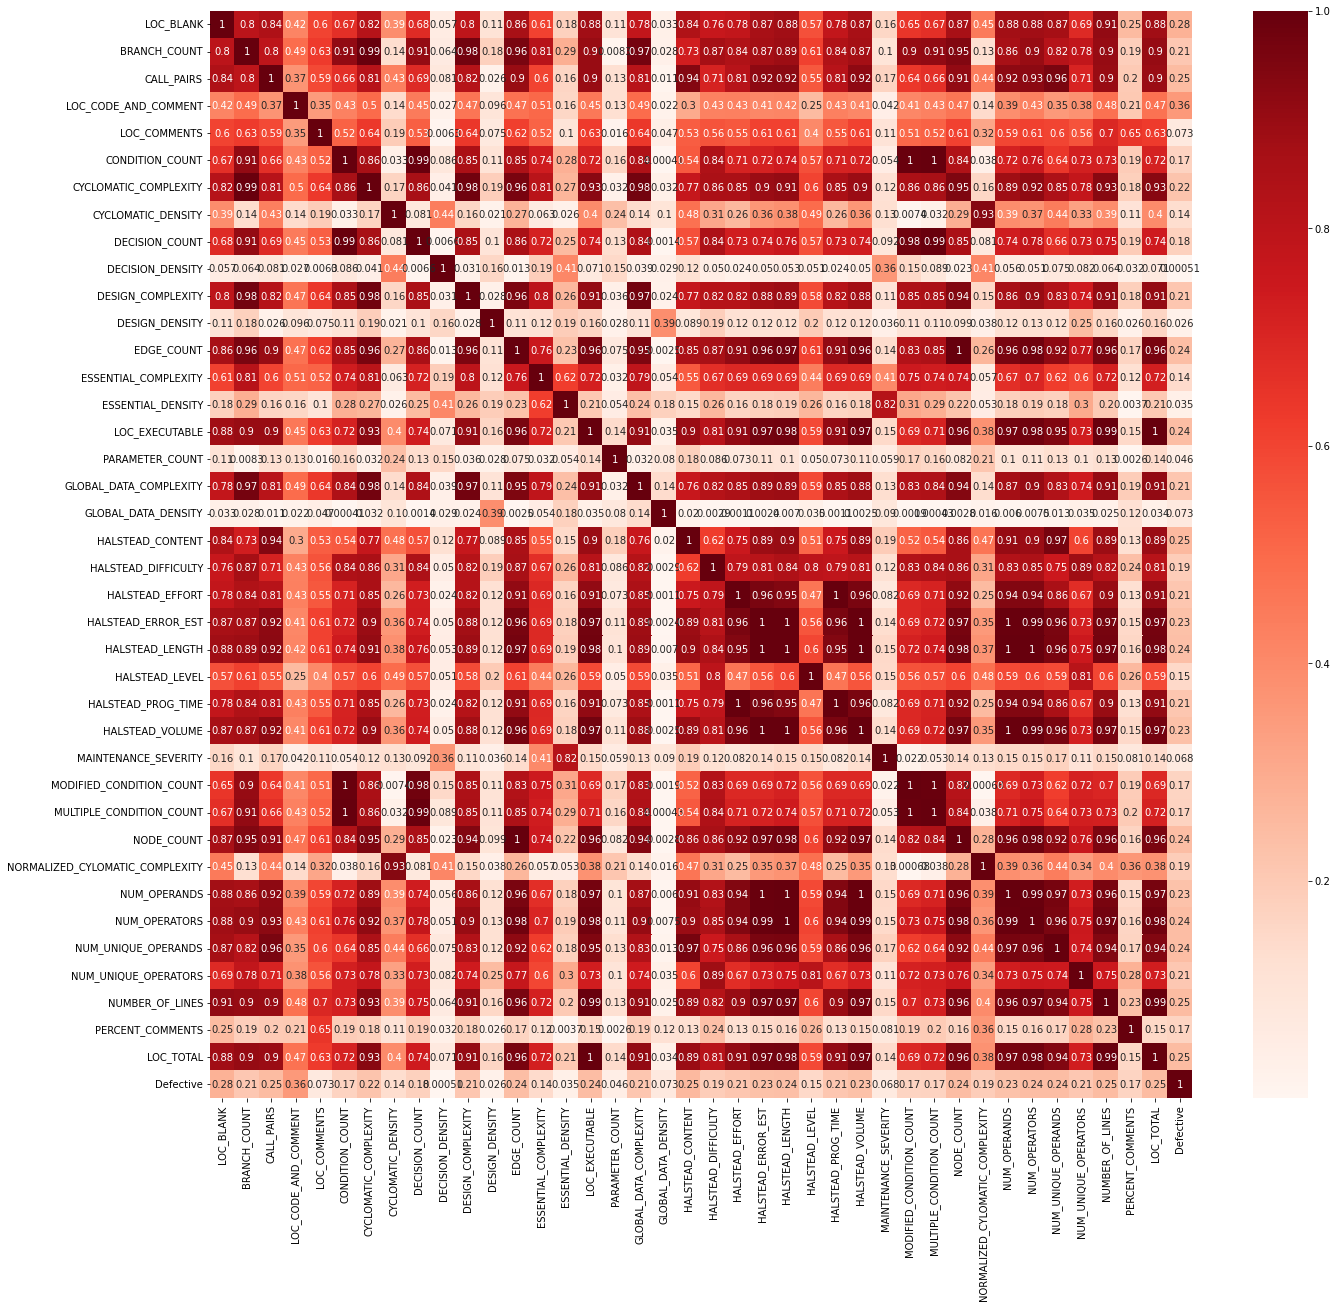

In [11]:
correlation_matrix = data.corr().abs()
plt.figure(figsize = (22, 20))
sns.heatmap(correlation_matrix, annot = True, cmap = plt.cm.Reds)
plt.show()

## Model training and testing with Hybrid Feature Selection

In [12]:
upper_triangular_matrix = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k = 1).astype(np.bool))
features_to_drop = [column for column in upper_triangular_matrix.columns if any(upper_triangular_matrix[column] > 0.95)]
print("Features to drop: ", features_to_drop)
data = data.drop(features_to_drop, axis = 1)
data.head()

Features to drop:  ['CYCLOMATIC_COMPLEXITY', 'DECISION_COUNT', 'DESIGN_COMPLEXITY', 'EDGE_COUNT', 'LOC_EXECUTABLE', 'GLOBAL_DATA_COMPLEXITY', 'HALSTEAD_ERROR_EST', 'HALSTEAD_LENGTH', 'HALSTEAD_PROG_TIME', 'HALSTEAD_VOLUME', 'MODIFIED_CONDITION_COUNT', 'MULTIPLE_CONDITION_COUNT', 'NODE_COUNT', 'NUM_OPERANDS', 'NUM_OPERATORS', 'NUM_UNIQUE_OPERANDS', 'NUMBER_OF_LINES', 'LOC_TOTAL']


,LOC_BLANK,BRANCH_COUNT,CALL_PAIRS,LOC_CODE_AND_COMMENT,LOC_COMMENTS,CONDITION_COUNT,CYCLOMATIC_DENSITY,DECISION_DENSITY,DESIGN_DENSITY,ESSENTIAL_COMPLEXITY,ESSENTIAL_DENSITY,PARAMETER_COUNT,GLOBAL_DATA_DENSITY,HALSTEAD_CONTENT,HALSTEAD_DIFFICULTY,HALSTEAD_EFFORT,HALSTEAD_LEVEL,MAINTENANCE_SEVERITY,NORMALIZED_CYLOMATIC_COMPLEXITY,NUM_UNIQUE_OPERATORS,PERCENT_COMMENTS,Defective
0,12.0,15.0,20.0,1.0,7.0,16.0,0.17,2.00,0.78,5.0,0.50,1.0,0.78,99.00,17.94,31877.94,0.06,0.56,0.12,19.0,13.33,1
1,0.0,3.0,4.0,0.0,0.0,4.0,0.25,2.00,1.00,1.0,0.00,2.0,1.00,20.81,9.00,1685.67,0.11,0.50,0.22,12.0,0.00,0
2,3.0,5.0,3.0,0.0,1.0,6.0,0.27,3.00,0.67,3.0,1.00,1.0,0.33,29.72,13.60,5496.65,0.07,1.00,0.19,12.0,8.33,0
3,11.0,43.0,16.0,0.0,4.0,76.0,0.21,2.24,0.77,12.0,0.52,3.0,0.82,70.89,48.94,169799.06,0.02,0.55,0.18,24.0,3.74,0
4,9.0,11.0,13.0,0.0,9.0,8.0,0.10,2.00,0.63,1.0,0.00,2.0,0.88,123.35,19.27,45791.28,0.05,0.13,0.08,18.0,10.23,1


In [13]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 10)

### K-Nearest Neighbour

In [15]:
knn = KNeighborsClassifier(n_neighbors=89)
sfs = SequentialFeatureSelector(knn)
X_train_sfs = sfs.fit_transform(X_train, y_train)
X_test_sfs = sfs.transform(X_test)
knn.fit(X_train_sfs, y_train)
print(f"Score: {knn.score(X_test_sfs, y_test)}")
y_pred = knn.predict(X_test_sfs)
print(f"MCC: {matthews_corrcoef(y_test, y_pred)}")

Score: 0.7627118644067796
MCC: 0.0


Selected features for KNN

In [16]:
selected_features_index = sfs.get_support(True)
data.columns[selected_features_index]

Index(['LOC_BLANK', 'BRANCH_COUNT', 'CALL_PAIRS', 'LOC_CODE_AND_COMMENT',
       'LOC_COMMENTS', 'CONDITION_COUNT', 'CYCLOMATIC_DENSITY',
       'DECISION_DENSITY', 'DESIGN_DENSITY', 'ESSENTIAL_COMPLEXITY'],
      dtype='object')

### Naive Bayes

In [17]:
gnb = GaussianNB()
sfs = SequentialFeatureSelector(gnb)
X_train_sfs = sfs.fit_transform(X_train, y_train)
X_test_sfs = sfs.transform(X_test)
gnb.fit(X_train_sfs, y_train)
print(f"Score: {gnb.score(X_test_sfs, y_test)}")
y_pred = gnb.predict(X_test_sfs)
print(f"MCC: {matthews_corrcoef(y_test, y_pred)}")

Score: 0.7288135593220338
MCC: 0.07596177114740713


Selected Features for Naive Bayes

In [18]:
selected_features_index = sfs.get_support(True)
data.columns[selected_features_index]

Index(['LOC_BLANK', 'LOC_CODE_AND_COMMENT', 'LOC_COMMENTS',
       'CYCLOMATIC_DENSITY', 'DESIGN_DENSITY', 'ESSENTIAL_DENSITY',
       'PARAMETER_COUNT', 'GLOBAL_DATA_DENSITY', 'HALSTEAD_CONTENT',
       'MAINTENANCE_SEVERITY'],
      dtype='object')

### Decision Tree

In [19]:
dtc = DecisionTreeClassifier()
sfs = SequentialFeatureSelector(dtc)
X_train_sfs = sfs.fit_transform(X_train, y_train)
X_test_sfs = sfs.transform(X_test)
dtc.fit(X_train_sfs, y_train)
print(f"Score: {dtc.score(X_test_sfs, y_test)}")
y_pred = dtc.predict(X_test_sfs)
print(f"MCC: {matthews_corrcoef(y_test, y_pred)}")

Score: 0.6440677966101694
MCC: 0.1271761288635376


Selected features for Decision Tree

In [20]:
selected_features_index = sfs.get_support(True)
data.columns[selected_features_index]

Index(['LOC_BLANK', 'LOC_CODE_AND_COMMENT', 'LOC_COMMENTS', 'CONDITION_COUNT',
       'DECISION_DENSITY', 'DESIGN_DENSITY', 'ESSENTIAL_COMPLEXITY',
       'PARAMETER_COUNT', 'NORMALIZED_CYLOMATIC_COMPLEXITY',
       'NUM_UNIQUE_OPERATORS'],
      dtype='object')

### Random Forest

In [21]:
rfc = RandomForestClassifier()
sfs = SequentialFeatureSelector(rfc)
X_train_sfs = sfs.fit_transform(X_train, y_train)
X_test_sfs = sfs.transform(X_test)
rfc.fit(X_train_sfs, y_train)
print(f"Score: {rfc.score(X_test_sfs, y_test)}")
y_pred = rfc.predict(X_test_sfs)
print(f"MCC: {matthews_corrcoef(y_test, y_pred)}")

Score: 0.7457627118644068
MCC: 0.05225453721073499


Selected features for Random Forest

In [22]:
selected_features_index = sfs.get_support(True)
data.columns[selected_features_index]

Index(['LOC_BLANK', 'BRANCH_COUNT', 'LOC_COMMENTS', 'CONDITION_COUNT',
       'DECISION_DENSITY', 'ESSENTIAL_COMPLEXITY', 'HALSTEAD_LEVEL',
       'MAINTENANCE_SEVERITY', 'NORMALIZED_CYLOMATIC_COMPLEXITY',
       'NUM_UNIQUE_OPERATORS'],
      dtype='object')

AdaBoost

In [23]:
abc = AdaBoostClassifier()
sfs = SequentialFeatureSelector(abc)
X_train_sfs = sfs.fit_transform(X_train, y_train)
X_test_sfs = sfs.transform(X_test)
abc.fit(X_train_sfs, y_train)
print(f"Score: {abc.score(X_test_sfs, y_test)}")
y_pred = abc.predict(X_test_sfs)
print(f"MCC: {matthews_corrcoef(y_test, y_pred)}")

Score: 0.7457627118644068
MCC: 0.11638287479252928


Selected features for AdaBoost Classifier

In [24]:
selected_features_index = sfs.get_support(True)
data.columns[selected_features_index]

Index(['LOC_BLANK', 'BRANCH_COUNT', 'CALL_PAIRS', 'LOC_CODE_AND_COMMENT',
       'LOC_COMMENTS', 'CONDITION_COUNT', 'DECISION_DENSITY', 'HALSTEAD_LEVEL',
       'MAINTENANCE_SEVERITY', 'NORMALIZED_CYLOMATIC_COMPLEXITY'],
      dtype='object')